In [1]:
from modules.base import *

Basic Schema

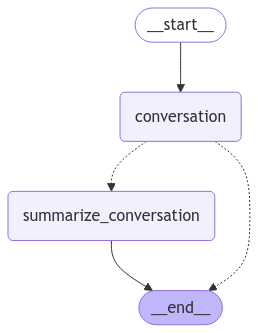

In [2]:
model = ChatOpenAI(model="gpt-4o", temperature=0) 

class State(MessagesState):
    summary: str

@auto_log_and_state
def conversation(state: State, config: RunnableConfig):
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    response = model.invoke(messages, config)
    return {"messages": response}

@auto_log_and_state
def summarize_conversation(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

@auto_log_and_state
def should_continue(state: State):    
    messages = state["messages"]
    print("length :",len(messages))
    if len(messages) > 6:
        return "summarize_conversation"
    return END

workflow = StateGraph(State)
workflow.add_node("conversation", conversation)
workflow.add_node("summarize_conversation", summarize_conversation)
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
config = {"configurable": {"thread_id": "1"}}
for chunk in graph.stream(
    {"messages": [HumanMessage(content="hi! I'm Lance")]}, 
    config=config,  # Pass config explicitly
    stream_mode="updates"
):
    print(chunk)


🚀 Executing Node: [conversation]
❌ Error in binding arguments for function 'conversation': missing a required argument: 'config'


TypeError: missing a required argument: 'config'

In [17]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, 
                          config, 
                          stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

length : 8
================================== Ai Message ==================================

Hi Lance! Let me know if there's anything you'd like to chat about or any questions you have.


KeyError: 'conversation'

Pydantic Schema

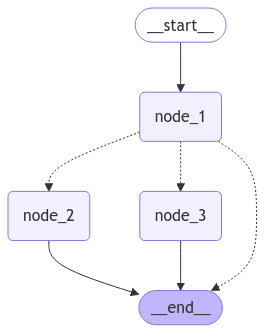


🚀 Passing Through [node_1] ..

#### [Input State]
name : changwoo
mood : sad

#### [Output State]
name : changwoo is

🚀 Passing Through [decide_mood] ..

#### [Input State]
name : changwoo is
mood : sad

⚠️ Output is not a valid state. Output can be routing or other: [node_3]

🚀 Passing Through [node_3] ..

#### [Input State]
name : changwoo is
mood : sad

#### [Output State]
name : changwoo is
mood : sad


{'name': 'changwoo is', 'mood': 'sad'}

In [3]:
class PydanticState(BaseModel):
    name: str
    mood: str

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value
    
@auto_log_and_state
def node_1(state):
    return {"name": state.name + " is"}

@auto_log_and_state
def node_2(state):
    state.mood = "happy"
    return state

@auto_log_and_state
def node_3(state):
    state.mood = "sad"
    return state

@auto_log_and_state
def decide_mood(state) -> Literal["node_2", "node_3"]:
    if random.random() < 0.5:
        return "node_2"
    return "node_3"

builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke(PydanticState(name="changwoo", mood="sad"))

Multiple Schema

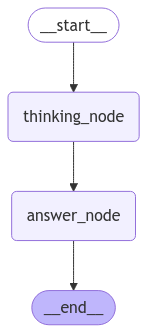


🚀 Passing Through [thinking_node] ..

#### [Input State]
question : How much is it?

#### [Output State]
answer : 
notes : he buy a apple

🚀 Passing Through [answer_node] ..

#### [Input State]
question : How much is it?
answer : 
notes : he buy a apple

#### [Output State]
answer : 2 dollars


{'answer': '2 dollars'}

In [10]:
class InputState(TypedDict):
    question: str # get only question key

class OutputState(TypedDict):
    answer: str # get only answer key

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

@auto_log_and_state
def thinking_node(state: InputState):
    return {"answer": "", "notes": "he buy a apple"}

@auto_log_and_state
def answer_node(state: OverallState) -> OutputState:
    return {"answer": "2 dollars"}

graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)
graph = graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke({"question":"How much is it?","note":"he is changwoo"}) 